# Brain Tumor Detection Using DL

The main purpose of this project is detecting tumors from MRI scans. 

source: [kaggle](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

### Import necessary modules

In [10]:
import os
import cv2
import shutil

from tqdm import tqdm
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



## Splitting the data

In [4]:
img_dir = '../../Datasets/brain_tumor_dataset/'
img_dir_data = '../../Datasets/brain_tumor_dataset/data/'
for category in os.listdir(img_dir_data):
    if not category.startswith('.'):
        img_num = len(os.listdir(img_dir_data+category))
        for n, img_name in enumerate(os.listdir(img_dir_data+category)):
            img = img_dir_data + category + '/' + img_name
            if n < 5:
                shutil.copy(img, 'TEST/' + category.upper() + '/' + img_name)
            elif n < 0.8*img_num:
                shutil.copy(img, 'TRAIN/' + category.upper() + '/' + img_name)
            else:
                shutil.copy(img, 'VAL/' + category.upper() + '/' + img_name)

## Data Import and Preprocessing

In [57]:
def load_data(dir_path, img_size=(100,100)):
    """ Load Images as np.arrays
    :params:
    :return:
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(os.listdir(dir_path)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path+path+'/'+file)
                    img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} image loaded from {dir_path} directory.')
    return X, y, labels

In [58]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 3/3 [00:00<00:00, 33.78it/s]

193 image loaded from TRAIN/ directory.
10 image loaded from TEST/ directory.
50 image loaded from VAL/ directory.


In [72]:
train_dist = np.array(np.unique(y_train, return_counts = True)).T
test_dist = np.array(np.unique(y_test, return_counts = True)).T
val_dist = np.array(np.unique(y_val, return_counts = True)).T

In [110]:
data_dist = pd.DataFrame({'Train':train_dist[:,1],'Val':val_dist[:,1], 'Test':test_dist[:,1]})
data_dist

,Train,Val,Test
0,74,19,5
1,119,31,5


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
negative_dir = os.path.join('../../Datasets/brain_tumor_dataset/no')
positive_dir = os.path.join('../../Datasets/brain_tumor_dataset/yes')

negative_names = os.listdir(negative_dir)
positive_names = os.listdir(positive_dir)

print("Total negative images: ", len(negative_names))
print("Total positive images: ", len(positive_names))

Total negative images:  98
Total positive images:  155


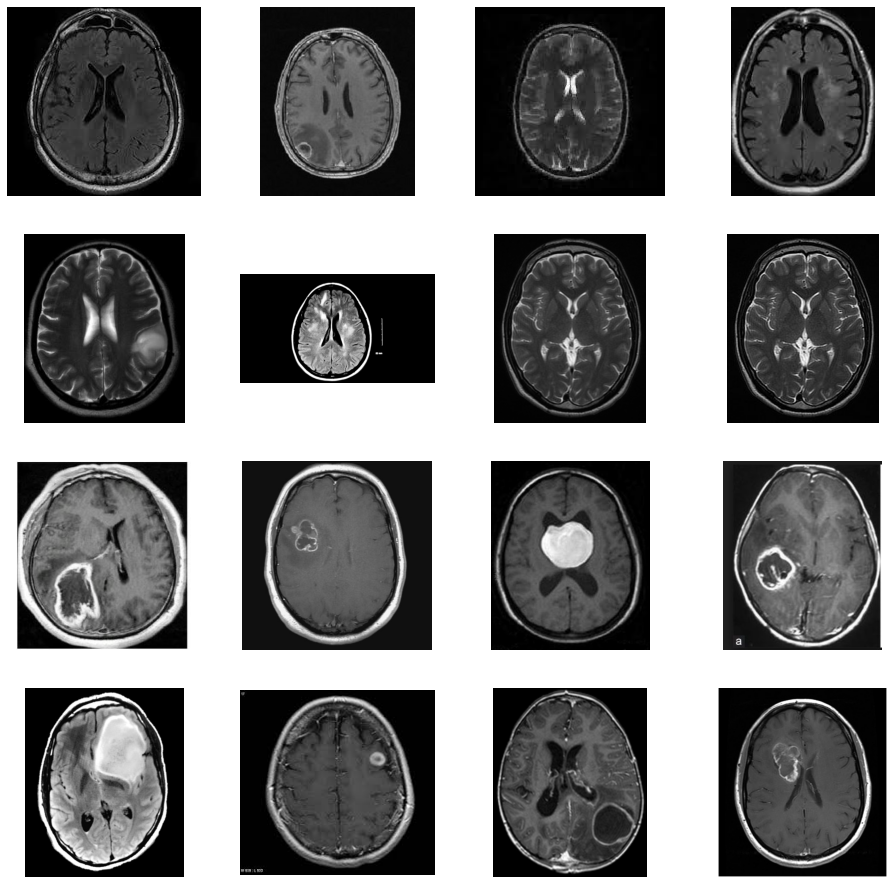

In [3]:
fig = plt.gcf()
fig.set_size_inches(16,16)
random_idx = np.random.randint(98, size=8)
random_negative = [os.path.join(negative_dir, negative_names[idx]) for idx in random_idx]
random_positive = [os.path.join(positive_dir, positive_names[idx]) for idx in random_idx]

for i, name in enumerate(random_negative+random_positive):
    sq = plt.subplot(4,4,i+1)
    sq.axis('Off')
    img = cv2.imread(name)
    plt.imshow(img)

In [8]:
train_datagen = ImageDataGenerator(rescale=1/255.)
train_generator = train_datagen.flow_from_directory(
    '../../Datasets/brain_tumor_dataset',
    target_size = (300,300),
    batch_size = 16,
    class_mode = 'binary'
)

Found 253 images belonging to 2 classes.


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1,  activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [7]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch = 16,
                    epochs = 15, 
                    verbose = 1)

Epoch 1/15
16/16 [==============================] - 9s 488ms/step - loss: 0.8526 - accuracy: 0.5968
Epoch 2/15
16/16 [==============================] - 8s 463ms/step - loss: 0.6103 - accuracy: 0.7352
Epoch 3/15
16/16 [==============================] - 8s 480ms/step - loss: 0.5278 - accuracy: 0.7510
Epoch 4/15
16/16 [==============================] - 8s 465ms/step - loss: 0.4792 - accuracy: 0.8182
Epoch 5/15
16/16 [==============================] - 8s 466ms/step - loss: 0.5189 - accuracy: 0.7747
Epoch 6/15
16/16 [==============================] - 7s 460ms/step - loss: 0.3840 - accuracy: 0.8300
Epoch 7/15
16/16 [==============================] - 8s 463ms/step - loss: 0.3647 - accuracy: 0.8617
Epoch 8/15
16/16 [==============================] - 8s 482ms/step - loss: 0.3057 - accuracy: 0.8656
Epoch 9/15
16/16 [==============================] - 8s 504ms/step - loss: 0.2578 - accuracy: 0.9249
Epoch 10/15
16/16 [==============================] - 11s 705ms/step - loss: 0.1878 - accuracy: 0.928